In [121]:
import numpy as np
import pandas as pd
import pyspark #importing pyspark module
# from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,udf,lit #udf(),col()
from pyspark.sql.types import FloatType #FloatType()from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier,LogisticRegression,DecisionTreeClassifier,LinearSVC
from pyspark.ml.feature import VectorAssembler 

In [46]:
spark = SparkSession.builder.appName("PDP").getOrCreate() #creating Pyspark Session for proceed further.


In [47]:
def train_ml():
    #Read Data
    data = spark.read.csv("./Data/glass.csv",header=True,inferSchema=True)
    
    #Feture col name
    data = data.drop("Index")
    col = data.columns[:-1]
    
    #Group feature
    feature_assembler = VectorAssembler(inputCols=col,outputCol="feature")
    data = feature_assembler.transform(data)

    #dataset contain only feature and class label
    data = data.select(["feature", "type"])
    train,test = data.randomSplit([.7,.3])
    
    #Create ML Classifirer
    rf_model = RandomForestClassifier(labelCol="type", featuresCol="feature")
    lr_model = LogisticRegression(labelCol="type", featuresCol="feature")
    sv_model = LinearSVC(maxIter=10, regParam=0.1, labelCol="type", featuresCol="feature")


    #train and return train model object
    rf_model = rf_model.fit(train)
    lr_model = lr_model.fit(train)
    sv_model = sv_model.fit(train)
    return rf_model,lr_model,sv_model,col

In [48]:
def get_data():
    data = spark.read.csv("./Data/glass.csv",header=True,inferSchema=True)
    #Feture col name
    data = data.drop("Index")
    col = data.columns[:-1]
    
    #Group feature
    feature_assembler = VectorAssembler(inputCols=col,outputCol="feature")
    data = feature_assembler.transform(data)
    
    #dataset contain only feature and class label
    data = data.select(["feature", "type"])
    train,test = data.randomSplit([.7,.3])
    return train,test

In [49]:
target_column = "type"
rf_model,lr_model,sv_model, col = train_ml()
train,test = get_data()

In [50]:
m = rf_model.transform(train)

In [8]:
rf_model

RandomForestClassificationModel: uid=RandomForestClassifier_60d1540c128d, numTrees=20, numClasses=2, numFeatures=9

In [9]:
rf_model.featureImportances

SparseVector(9, {0: 0.2295, 1: 0.0435, 2: 0.1166, 3: 0.2684, 4: 0.0767, 5: 0.0984, 6: 0.1101, 7: 0.0149, 8: 0.0419})

In [10]:
model = pd.DataFrame(rf_model.featureImportances.values, columns=["values"])


In [11]:
features_col = pd.Series(col)
model["features"] = features_col
model


,values,features
0,0.229508,ri
1,0.043539,na
2,0.116612,mg
3,0.268386,al
4,0.076663,si
5,0.098372,k
6,0.110124,ca
7,0.014875,ba
8,0.041921,fe


In [12]:

model = model.sort_values(by=['values'], ascending=False).round(2)
model.iloc[:4]

,values,features
3,0.27,al
0,0.23,ri
2,0.12,mg
6,0.11,ca


In [51]:
import numpy as np
import pandas as pd
import plotly as py
import plotly.tools as tls
import plotly.offline as pyo
import plotly.graph_objs as go

In [14]:
lr_model.coefficients

DenseVector([-74.7762, 0.2778, 2.2952, -5.4551, 1.4203, 1.2309, 0.6576, -6.1314, -5.5391])

In [15]:
sv_model.coefficients

DenseVector([0.59, -0.0, 0.0033, -0.0046, 0.0013, -0.0031, -0.0, -0.0031, -0.0025])

In [16]:
print("Multinomial coefficients: " + str(lr_model.coefficientMatrix.values))
print("Multinomial intercepts: " + str(lr_model.interceptVector))

Multinomial coefficients: [-74.77615636   0.27776015   2.29520498  -5.45513986   1.42025041
   1.23091892   0.65764075  -6.13138296  -5.53912498]
Multinomial intercepts: [0.03640969775046919]


In [17]:
print(lr_model.coefficients.values)
print(lr_model.intercept)

[-74.77615636   0.27776015   2.29520498  -5.45513986   1.42025041
   1.23091892   0.65764075  -6.13138296  -5.53912498]
0.03640969775046919


In [18]:
coff = lr_model.coefficientMatrix.values
coff

array([-74.77615636,   0.27776015,   2.29520498,  -5.45513986,
         1.42025041,   1.23091892,   0.65764075,  -6.13138296,
        -5.53912498])

In [19]:
model = pd.DataFrame(lr_model.coefficients.values, columns=["values"])
features_col = pd.Series(col)
model["features"] = features_col
model = model.sort_values(by=['values'], ascending=False).round(2)
model

,values,features
2,2.30,mg
4,1.42,si
5,1.23,k
6,0.66,ca
1,0.28,na
3,-5.46,al
8,-5.54,fe
7,-6.13,ba
0,-74.78,ri


In [20]:
model["values"]= model.iloc[:,0]/np.sum(model.iloc[:,0])

In [21]:
model

,values,features
2,-0.026738,mg
4,-0.016508,si
5,-0.014299,k
6,-0.007673,ca
1,-0.003255,na
3,0.063474,al
8,0.064404,fe
7,0.071262,ba
0,0.869333,ri


In [35]:
fi = pd.DataFrame((lr_model.coefficients.values/np.sum(lr_model.coefficients.values)), columns=["values"])


In [36]:
fi

,values
0,0.869288
1,-0.003229
2,-0.026682
3,0.063417
4,-0.016511
5,-0.014310
6,-0.007645
7,0.071279
8,0.064393


In [37]:
# fi["values"] = fi.iloc[:, 0] / np.sum(fi.iloc[:, 0])

In [38]:
trace = go.Bar(x=model["features"], y=model["values"]*100, marker=dict(color='#32E0C4'))
data = [trace]
layout = go.Layout()
fig = go.Figure(data=data, layout=layout)
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)', 'paper_bgcolor': 'rgba(0,0,0,0)'})
fig.update_layout(title_text="<b>RANDOM FOREST BASED FEATURE IMPORTANCE<b> ", title_x=0.5)
fig.update_xaxes(title_text='Features')
fig.update_yaxes(title_text='Feature Importance %')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')

In [40]:
pyo.plot(fig)

'temp-plot.html'

In [41]:

def feat_imp(model, data,  target, depth):
    if model.lower() == "RandomForestClassifier".lower():
        features = data.drop(target)
        data = VectorAssembler(inputCols=features.columns, outputCol="feature").transform(data)
        model = RandomForestClassifier(labelCol=target, featuresCol="feature", numTrees=10)
        model = model.fit(data)
        fi = pd.DataFrame(model.featureImportances.values, columns=["values"])
        features_col = pd.Series(features.columns)
        fi["features"] = features_col
        fi = fi.sort_values(by=['values'], ascending=False).round(2)
        fi = fi.iloc[:depth]
        trace = go.Bar(x=fi["features"], y=fi["values"], marker=dict(color='#32E0C4'))
        data = [trace]
        layout = go.Layout()
        fig = go.Figure(data=data, layout=layout)
        fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)', 'paper_bgcolor': 'rgba(0,0,0,0)'})
        fig.update_layout(title_text="<b>RANDOM FOREST BASED FEATURE IMPORTANCE<b> ", title_x=0.5)
        fig.update_xaxes(title_text='Features')
        fig.update_yaxes(title_text='Feature Importance %')
        fig.update_xaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
        fig.update_yaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
        return fi, fig
    elif model.lower() == "LogisticRegression".lower():
        features = data.drop(target)
        data = VectorAssembler(inputCols=features.columns, outputCol="feature").transform(data)
        model = LogisticRegression(labelCol=target, featuresCol="feature")
        model = model.fit(data)
        fi = pd.DataFrame(model.coefficients.values/np.sum(model.coefficients.values), columns=["values"])
        features_col = pd.Series(features.columns)
        fi["features"] = features_col
        fi = fi.sort_values(by=['values'], ascending=False).round(2)
        fi = fi.iloc[:depth]
        trace = go.Bar(x=fi["features"], y=fi["values"]*100, marker=dict(color='#32E0C4'))
        data = [trace]
        layout = go.Layout()
        fig = go.Figure(data=data, layout=layout)
        fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)', 'paper_bgcolor': 'rgba(0,0,0,0)'})
        fig.update_layout(title_text="<b>Logistic Regression BASED FEATURE IMPORTANCE<b> ", title_x=0.5)
        fig.update_xaxes(title_text='Features')
        fig.update_yaxes(title_text='Feature Importance %')
        fig.update_xaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
        fig.update_yaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
        return fi, fig
    elif model.lower() == "LinearSVC".lower():
        features = data.drop(target)
        data = VectorAssembler(inputCols=features.columns, outputCol="feature").transform(data)
        model = LinearSVC(maxIter=10, regParam=0.1, labelCol="type", featuresCol="feature")
        model = model.fit(data)
        fi = pd.DataFrame(model.coefficients.values, columns=["values"])
        features_col = pd.Series(features.columns)
        fi["features"] = features_col
        fi = fi.sort_values(by=['values'], ascending=False).round(2)
        fi = fi.iloc[:depth]
        data = [trace]
        layout = go.Layout()
        fig = go.Figure(data=data, layout=layout)
        fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)', 'paper_bgcolor': 'rgba(0,0,0,0)'})
        fig.update_layout(title_text="<b>LinearSVC BASED FEATURE IMPORTANCE<b> ", title_x=0.5)
        fig.update_xaxes(title_text='Features')
        fig.update_yaxes(title_text='Feature Importance %')
        fig.update_xaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
        fig.update_yaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
        return fi, fig


In [42]:
data = spark.read.csv("./Data/glass.csv",header=True,inferSchema=True)

#Feture col name
data = data.drop("Index")
target="type"
depth =8

In [43]:
# LinearSVC,RandomForestClassifier,LinearSVC
fi,fig = feat_imp("RandomForestClassifier", data,  target, depth)


In [44]:
pyo.plot(fig)

'temp-plot.html'

In [60]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [ ]:
import matplotlib.pyplot as plt

# Create a Pipeline estimator and fit on train DF, predict on test DF
predictions = lr_model.transform(train)


# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('type','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['type'])))
points = CurveMetrics(preds).get_curve('roc')


plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(x_val, y_val)

In [86]:
predictions = rf_model.transform(train)


In [ ]:
from handyspark import BinaryClassificationMetrics


In [109]:
train

DataFrame[feature: vector, type: int]

In [ ]:
stratify(['Pclass']).cols[['Age', 'logFare']].scatterplot(figsize=(12, 6))

In [105]:
bcm = BinaryClassificationMetrics(preds)

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

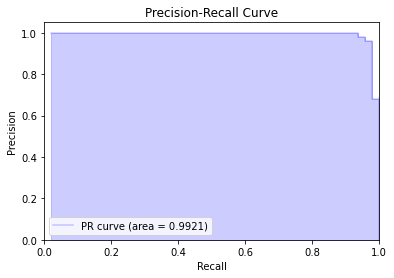

In [108]:
bcm.plot_pr_curve()

In [87]:
preds = predictions.select('type','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['type'])))
preds

PythonRDD[984] at RDD at PythonRDD.scala:53

In [56]:
# BCM = predictions.select(col("prediction").cast('float'),col("type").cast('float')).rdd.map(tuple)


In [ ]:
# type(preds)

In [ ]:
# model_fpr = np.array([x[0] for x in points])
# model_tpr = np.array([x[1] for x in points])

In [ ]:
from plotly.subplots import make_subplots

go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=model_fpr, y=1 - model_tpr, mode='lines', name='Specificity', line=dict(color='rgba(0,0,0,255)')))
fig.add_trace(go.Scatter(x=model_fpr, y=model_tpr, mode='lines', name='Sensitivity', line=dict(color='rgba(0,0,255,255)')),secondary_y=True)
fig.update_layout(title_text=f"<b>SPECIFICITY VS SENSITIVITY<b>", title_x=0.5)
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)', 'paper_bgcolor': 'rgba(0,0,0,0)'})
fig.update_yaxes(title_text='Specificity ')
fig.update_yaxes(title_text='Sensitivity')
fig.update_xaxes(title_text='Cutoff')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=-0.23, xanchor="right", x=0.6))

In [ ]:
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=model_fpr, y=model_tpr, mode='lines', name="ROC", line=dict(color='rgba(0,0,0,255)')))
fig.update_layout(title_text=f"<b>ROC AUC Curve<b>", title_x=0.5)
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)', 'paper_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(title_text='False Positive Rate')
fig.update_yaxes(title_text='True Positive Rate')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=-0.23, xanchor="right", x=0.6))

In [ ]:
pyo.plot(fig)

In [ ]:
predictions

In [ ]:
model_fpr, model_tpr = lr_model.summary.roc.select(["FPR"]).toPandas(), lr_model.summary.roc.select(["TPR"]).toPandas()


In [ ]:
plt.figure()
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(model_fpr, model_tpr)

In [ ]:
from sklearn.metrics import roc_curve


In [88]:
y = predictions.select(target_column).toPandas()
prob = udf(lambda v: float(v[1]), FloatType())
proba = predictions.select(prob('probability')).toPandas()
# model_fpr, model_tpr, _ = roc_curve(y, proba)

In [95]:
points = metrics.get_curve('roc')
model_fpr = np.array([x[0] for x in points])
model_tpr = np.array([x[1] for x in points])

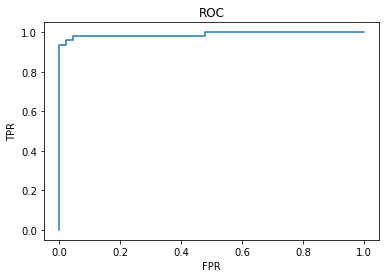

In [96]:
plt.figure()
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(model_fpr, model_tpr)

In [97]:
metrics = CurveMetrics(preds)
# # metrics.get_curve('roc')
# # metrics.get_curve('fMeasureByThreshold')
# metrics.get_curve('precisionByThreshold')
# # metrics.get_curve('recallByThreshold')
# # metrics.get_curve('recallByThreshold')
# # metrics.areaUnderROC
# # metrics.areaUnderPR

In [92]:
# metrics.get_curve('roc')
# metrics.get_curve('fMeasureByThreshold')
p_point=metrics.get_curve('precisionByThreshold')
r_point=metrics.get_curve('recallByThreshold')
# metrics.get_curve('recallByThreshold')
# metrics.areaUnderROC
# metrics.areaUnderPR

In [99]:
rec

array([0.94801587, 0.9386849 , 0.92370085, 0.903252  , 0.89298115,
       0.88086404, 0.8808437 , 0.87214782, 0.86989343, 0.85854933,
       0.85408172, 0.85079365, 0.84446925, 0.84416109, 0.83979601,
       0.83786075, 0.83522917, 0.8308437 , 0.80780493, 0.80478671,
       0.80421852, 0.77345933, 0.77187049, 0.76674473, 0.76391599,
       0.74527438, 0.74444444, 0.7120937 , 0.70683427, 0.70550821,
       0.68850668, 0.66946925, 0.65725633, 0.64538916, 0.62462121,
       0.61843645, 0.61277647, 0.55127509, 0.54508632, 0.53638889,
       0.52185852, 0.51446267, 0.50931116, 0.50707071, 0.44585859,
       0.36424964, 0.3375    , 0.31530303, 0.29513435, 0.2773967 ,
       0.25548067, 0.24255051, 0.21619769, 0.21448524, 0.21373512,
       0.19282287, 0.18248512, 0.17438783, 0.15647547, 0.15643939,
       0.15      , 0.1413961 , 0.1359375 , 0.11073232, 0.10643939,
       0.10416667, 0.09861111, 0.08689052, 0.07234848, 0.06782297,
       0.05643939, 0.05643939, 0.05416667, 0.05      , 0.04255

In [93]:
pre = np.array([x[0] for x in p_point])
rec = np.array([x[0] for x in r_point])


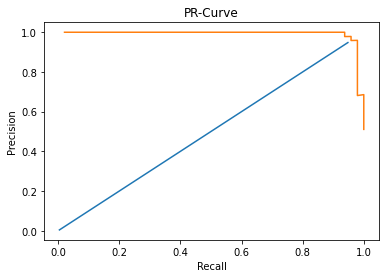

In [94]:
import matplotlib.pyplot as plt
plt.figure()
plt.title("PR-Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(r_point, p_point)

In [2]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import DataType,StringType,FloatType

In [191]:
from scikitplot.helpers import cumulative_gain_curve


In [3]:
@pandas_udf('double', PandasUDFType.SCALAR)
def plot_lift_curve(y_true, y_probas):
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)
    classes = set(y_true)
    print(classes)
    if len(classes) != 2:
        raise ValueError('Cannot calculate Lift Curve for data with '
                         '{} category/ies'.format(len(classes)))

    # Compute Cumulative Gain Curves
    percentages, gains1 = cumulative_gain_curve(y_true, y_probas[:, 0],
                                                classes[0])
    percentages, gains2 = cumulative_gain_curve(y_true, y_probas[:, 1],
                                                classes[1])

    percentages = percentages[1:]
    gains1 = gains1[1:]
    gains2 = gains2[1:]

    gains1 = gains1 / percentages
    gains2 = gains2 / percentages
#     fig = go.Figure()
#     fig.add_trace(go.Scatter(x=percentages, y=gains1,
#                     mode='lines+markers',
#                     name='Class 0',
#                     line=dict(color='blue', width=4)))
#     fig.add_trace(go.Scatter(x=percentages, y=gains2,
#                     mode='lines+markers',
#                     name='Class 1',
#                     line=dict(color='orange', width=4)))
#     fig.add_trace(go.Scatter(x=[0,1], y=[1,1],
#                     mode='lines',
#                     name='Baseline',
#                     line=dict(color='black', width=4,dash = 'dash')))
#     fig.update_layout(
#     title="Lift Curve",
#     yaxis_title="Lift",
#     xaxis_title="Percentage of sample",
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="#7f7f7f"))
    return percentages, gains1,percentages, gains2

/Users/aj/opt/anaconda3/envs/master/lib/python3.9/site-packages/pyspark/sql/pandas/functions.py:383: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


AttributeError: 'NoneType' object has no attribute '_jvm'

In [193]:
prob=udf(lambda v : float(v[1]), FloatType())
m = m.withColumn("y_prob", prob(col("probability")))

In [127]:
m.show()

+--------------------+----+--------------------+--------------------+----------+-----------+
|             feature|type|       rawPrediction|         probability|prediction|     y_prob|
+--------------------+----+--------------------+--------------------+----------+-----------+
|[1.51215,12.99,3....|   1|[5.09451235039470...|[0.25472561751973...|       1.0| 0.74527436|
|[1.51409,14.25,3....|   0|[17.9166666666666...|[0.89583333333333...|       0.0|0.104166664|
|[1.51567,13.29,3....|   1|[9.71074656337814...|[0.48553732816890...|       1.0| 0.51446265|
|[1.51569,13.24,3....|   0|[18.8712121212121...|[0.94356060606060...|       0.0|0.056439392|
|[1.51571,12.72,3....|   1|[17.8712121212121...|[0.89356060606060...|       0.0|  0.1064394|
|[1.51574,14.86,3....|   0|          [17.0,3.0]|         [0.85,0.15]|       0.0|       0.15|
|[1.51588,13.12,3....|   0|[15.1489898989899...|[0.75744949494949...|       0.0|  0.2425505|
|[1.5159,13.24,3.3...|   0|[19.8712121212121...|[0.99356060606060...| 

In [199]:
y = m.select("type").toPandas()
y_prob = m.select("y_prob").toPandas()

In [200]:
type(y_prob)

pandas.core.frame.DataFrame

In [209]:
f1,f2,f3,f4 = m.select(plot_lift_curve(y,y_prob))

TypeError: Invalid argument, not a string or column:     type
0      1
1      0
2      1
3      0
4      1
..   ...
89     1
90     0
91     0
92     0
93     0

[94 rows x 1 columns] of type <class 'pandas.core.frame.DataFrame'>. For column literals, use 'lit', 'array', 'struct' or 'create_map' function.

In [114]:
type(m)

pyspark.sql.dataframe.DataFrame

In [81]:
def feature_importance_graph_ModelComparison(target_column, data):
    """

    :param target_column:
    :param data:
    :return:
    """
    features = data.drop(target_column)
    data = VectorAssembler(inputCols=features.columns, outputCol="feature").transform(data)
    rf_model = RandomForestClassifier(labelCol=target_column, featuresCol="feature", numTrees=10)
    rf_model = rf_model.fit(data)
    fi = pd.DataFrame(rf_model.featureImportances.values, columns=["values"])
    features_col = pd.Series(features.columns)
    fi["features"] = features_col
    fi = fi.sort_values(by=['values'], ascending=False).round(2)
    trace = go.Bar(x=fi["features"], y=fi["values"], marker=dict(color='#32E0C4'))
    data = [trace]
    layout = go.Layout()
    fig = go.Figure(data=data, layout=layout)
    fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)', 'paper_bgcolor': 'rgba(0,0,0,0)'})
    fig.update_layout(title_text="<b>RANDOM FOREST BASED FEATURE IMPORTANCE<b> ", title_x=0.5)
    fig.update_xaxes(title_text='Features')
    fig.update_yaxes(title_text='Feature Importance')
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
    return fi, fig

In [ ]:

def lift_OngoingComparison(ann_fpr, ann_tpr, ns_fpr, ns_tpr, ann_auc, ann_fpr2, ann_tpr2, ns_fpr2, ns_tpr2, ann_auc2, name, user):
    """

    :param ann_fpr:
    :param ann_tpr:
    :param ns_fpr:
    :param ns_tpr:
    :param ann_auc:
    :param ann_fpr2:
    :param ann_tpr2:
    :param ns_fpr2:
    :param ns_tpr2:
    :param ann_auc2:
    :param name:
    :param user:
    :return:
    """
    helper = Model_helper(username=user)
    colors = helper.preference_maker(2)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ann_fpr, y=ann_tpr, mode='lines', name=f'{name}', line=dict(color = colors[0])))
    fig.add_trace(go.Scatter(x=ns_fpr, y=ns_tpr, mode='lines', name='No Skill', line=dict(color = colors[1])))
    fig.add_annotation(x=max(ns_fpr), y=0.05, showarrow=False, text="AUC : " + str(ann_auc))
    fig.update_layout(title_text=f"Monitoring ROC AUC Curve", title_x=0.5)
    fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)', 'paper_bgcolor': 'rgba(0,0,0,0)'})
    fig.update_xaxes(title_text='False Positive Rate')
    fig.update_yaxes(title_text='True Positive Rate')
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
    fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=-0.23, xanchor="right", x=0.6))

    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=ann_fpr2, y=ann_tpr2, mode='lines', name=f'{name}', line=dict(color=colors[0])))
    fig2.add_trace(go.Scatter(x=ns_fpr2, y=ns_tpr2, mode='lines', name='No Skill', line=dict(color=colors[1])))
    fig2.add_annotation(x=max(ns_fpr2), y=0.05, showarrow=False, text="AUC : " + str(ann_auc2))
    fig2.update_layout(title_text=f"Development ROC AUC Curve", title_x=0.5)
    fig2.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)', 'paper_bgcolor': 'rgba(0,0,0,0)'})
    fig2.update_xaxes(title_text='False Positive Rate')
    fig2.update_yaxes(title_text='True Positive Rate')
    fig2.update_xaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
    fig2.update_yaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
    fig2.update_layout(legend=dict(orientation="h", yanchor="bottom", y=-0.23, xanchor="right", x=0.6))
    return fig, fig2

# ROC AUC function for ModelComparison
def lift_ModelComparison(ann_fpr, ann_tpr, ns_fpr, ns_tpr, ann_auc, name, user ):
    """

    :param ann_fpr:
    :param ann_tpr:
    :param ns_fpr:
    :param ns_tpr:
    :param ann_auc:
    :param name:
    :param user:
    :return:
    """
    helper = Model_helper(username=user)
    colors = helper.preference_maker(2)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ann_fpr, y=ann_tpr, mode='lines', name=f'{name}', line=dict(color = colors[0])))
    fig.add_trace(go.Scatter(x=ns_fpr, y=ns_tpr, mode='lines', name='No Skill', line=dict(color = colors[1])))
    fig.add_annotation(x=max(ns_fpr), y=0.05, showarrow=False, text="AUC : " + str(ann_auc))
    fig.update_layout(title_text=f"<b>ROC AUC Curve<b>", title_x=0.5)
    fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)', 'paper_bgcolor': 'rgba(0,0,0,0)'})
    fig.update_xaxes(title_text='False Positive Rate')
    fig.update_yaxes(title_text='True Positive Rate')
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
    fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=-0.23, xanchor="right", x=0.6))
    return fig


def draw_AUC_ModelComparison(model, target_column, name, user):
    """

    :param model:
    :param name:
    :param target_column:
    :param user:
    :return:
    """
    model = model.withColumn("ns_prob",lit(0.0))
    # fpr and tpr only possible in spark lr model
    BCM = model.select(target_column, 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['type'])))
    metrics = CurveMetrics(BCM)
    model_auc = metrics.areaUnderROC
    points = metrics.get_curve('roc')
    model_fpr = np.array([x[0] for x in points])
    model_tpr = np.array([x[1] for x in points])
    
    BCM = model.select(target_column, 'ns_prob').rdd.map(lambda row: (float(row['ns_prob']), float(row['type'])))
    metrics = CurveMetrics(BCM)
    points = metrics.get_curve('roc')
    ns_fpr = np.array([x[0] for x in points])
    ns_tpr = np.array([x[1] for x in points])
    return lift_ModelComparison(model_fpr, model_tpr, ns_fpr, ns_tpr, model_auc, name, user)


# ROC AUC Curve
def draw_AUC_OngoingComparison(train_model, test_model, target_column, name, user):
    """

    :param train_model:
    :param test_model:
    :param target_column:
    :param name:
    :param user:
    :return:
    """
    # fpr and tpr only possible in spark lr model
    # ROC for Train Data
    train_model = train_model.withColumn("ns_prob",lit(0.0))
    test_model = test_model.withColumn("ns_prob",lit(0.0))

    BCM = train_model.select(target_column, 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['type'])))
    metrics = CurveMetrics(BCM)
    train_model_auc = metrics.areaUnderROC
    points = metrics.get_curve('roc')
    train_model_fpr = np.array([x[0] for x in points])
    train_model_tpr = np.array([x[1] for x in points])
    
    BCM = train_model.select(target_column, 'ns_prob').rdd.map(lambda row: (float(row['ns_prob']), float(row['type'])))
    metrics = CurveMetrics(BCM)
    points = metrics.get_curve('roc')
    ns_fpr = np.array([x[0] for x in points])
    ns_tpr = np.array([x[1] for x in points])

    # ROC for Test Data
    BCM = test_model.select(target_column, 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['type'])))
    metrics = CurveMetrics(BCM)
    test_model_auc = metrics.areaUnderROC
    points = metrics.get_curve('roc')
    test_model_fpr = np.array([x[0] for x in points])
    test_model_tpr = np.array([x[1] for x in points])
    
    BCM = test_model.select(target_column, 'ns_prob').rdd.map(lambda row: (float(row['ns_prob']), float(row['type'])))
    metrics = CurveMetrics(BCM)
    points = metrics.get_curve('roc')
    ns_fpr2 = np.array([x[0] for x in points])
    ns_tpr2 = np.array([x[1] for x in points])

    return lift_OngoingComparison(train_model_fpr, train_model_tpr, ns_fpr, ns_tpr, train_model_auc, test_model_fpr, test_model_tpr, ns_fpr2, ns_tpr2, test_model_auc, name, user)


In [ ]:
target_column = "type"
rf_model,lr_model,sv_model, col = train_ml()
train,test = get_data()

In [ ]:
tlr_model = lr_model.transform(train)
trf_model = rf_model.transform(train)
tsv_model = sv_model.transform(train)


In [ ]:

tlr_model = tlr_model.withColumn("ns_prob",lit(0.0))

In [ ]:
tlr_model.printSchema

In [ ]:

pyo.plot(draw_AUC_ModelComparison(tlr_model,"type","AJAY",3))


In [ ]:
train_model = lr_model.transform(train)
test_model = lr_model.transform(test)

In [ ]:
f1, f2 = draw_AUC_OngoingComparison(train_model, test_model, "type", "AJAY", 4)

In [ ]:
pyo.plot(f1)

In [ ]:
pyo.plot(f2)

In [ ]:
type(lr_model.select("prediction").count())

In [ ]:
def graph_sen_OngoingComparison(train_model, test_model, target_column):
    """

    :param train_model:
    :param test_model:
    :param user:
    :return:
    """
#     helper = Model_helper(username=user)
#     colors = helper.preference_maker(2)
    # ROC for train dataset
    preds = train_model.select(target_column, 'probability').rdd.map(
            lambda row: (float(row['probability'][1]), float(row['type'])))
    points = CurveMetrics(preds).get_curve('roc')
    model_fpr = np.array([x[0] for x in points])
    model_tpr = np.array([x[1] for x in points])
    go.Figure()
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=model_fpr, y=1 - model_tpr,
                             mode='lines',
                             name='Specificity',
                             line=dict(color='rgba(255,0,0,255)'),
                             ))

    fig.add_trace(go.Scatter(x=model_fpr, y=model_tpr, mode='lines', name='Sensitivity', line=dict(color='rgba(0,0,255,255)')),
                  secondary_y=True, )
    fig.update_layout(title_text=f"Development<br>Specificity vs Sensitivity", title_x=0.5)
    fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)', 'paper_bgcolor': 'rgba(0,0,0,0)'})
    fig.update_yaxes(title_text='Specificity')
    fig.update_yaxes(title_text='Sensitivity')
    fig.update_xaxes(title_text='Cutoff')
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
    fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=-0.23, xanchor="right", x=0.6))

    # ROC for test dataset
    preds = test_model.select(target_column, 'probability').rdd.map(
            lambda row: (float(row['probability'][1]), float(row['type'])))
    points = CurveMetrics(preds).get_curve('roc')
    model_fpr = np.array([x[0] for x in points])
    model_tpr = np.array([x[1] for x in points])
    go.Figure()
    fig2 = make_subplots(specs=[[{"secondary_y": True}]])
    fig2.add_trace(go.Scatter(x=model_fpr, y=1 - model_tpr, mode='lines',
                              name='Specificity',
                              line=dict(color='rgba(255,0,0,255)'),
                              ))
    fig2.add_trace(go.Scatter(x=model_fpr, y=model_tpr, mode='lines', name='Sensitivity', line=dict(color='rgba(0,0,255,255)')),
                   secondary_y=True, )
    fig2.update_layout(title_text=f"Monitoring<br>Specificity vs Sensitivity", title_x=0.5)
    fig2.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)', 'paper_bgcolor': 'rgba(0,0,0,0)'})
    fig2.update_yaxes(title_text='Specificity')
    fig2.update_yaxes(title_text='Sensitivity')
    fig2.update_xaxes(title_text='Cutoff')
    fig2.update_xaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
    fig2.update_yaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
    fig2.update_layout(legend=dict(orientation="h", yanchor="bottom", y=-0.23, xanchor="right", x=0.6))
    return fig, fig2


def graph_sen_ModelComparison(test_model,target_column):
    """

    :param test_model:
    :param user:
    :return:
    """
#     helper = Model_helper(username=user)
#     colors = helper.preference_maker(2)

    # ROC for test dataset
    preds = test_model.select(target_column, 'probability').rdd.map(
        lambda row: (float(row['probability'][1]), float(row['type'])))
    points = CurveMetrics(preds).get_curve('roc')
    model_fpr = np.array([x[0] for x in points])
    model_tpr = np.array([x[1] for x in points])
    go.Figure()
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=model_fpr, y=1 - model_tpr, mode='lines', name='Specificity', line=dict(color='rgba(255,0,0,255)')))
    fig.add_trace(go.Scatter(x=model_fpr, y=model_tpr, mode='lines', name='Sensitivity', line=dict(color='rgba(0,0,255,255)')),secondary_y=True)
    fig.update_layout(title_text=f"<b>SPECIFICITY VS SENSITIVITY<b>", title_x=0.5)
    fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)', 'paper_bgcolor': 'rgba(0,0,0,0)'})
    fig.update_yaxes(title_text='Specificity ')
    fig.update_yaxes(title_text='Sensitivity')
    fig.update_xaxes(title_text='Cutoff')
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', rangemode='nonnegative')
    fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=-0.23, xanchor="right", x=0.6))
    return fig



In [ ]:
t_lr_model = lr_model.transform(test)
t_rf_model = rf_model.transform(test)
t_sv_model = sv_model.transform(test)


In [ ]:
f1, f2 = graph_sen_OngoingComparison(tlr_model,t_lr_model,"type")


In [ ]:
pyo.plot(f1)

In [ ]:
pyo.plot(f2)

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics  # MM for cm and BM for roc,auc
from pyspark.ml.evaluation import MulticlassClassificationEvaluator  # P,R,F-1,TPR,FPR

In [ ]:

def cm_fig(cm):
    """

    :param cm:
    :return:
    """
    x = ['Positive', 'Negative']
    y = ['Positive', 'Negative']

    fig = go.Figure()
    for step in range(9):
        fig.add_trace(go.Heatmap(visible=False, x=x, y=y, z=cm, colorscale="teal"))
    fig.data[4].visible = True

    anno2 = []
    for i, row in enumerate(cm):
        for j, value2 in enumerate(row):
            anno2.append(
                {
                    "x": x[j],
                    "y": y[i],
                    "font": {"color": "white", "size": 16},
                    "text": str(value2),
                    "xref": "x1",
                    "yref": "y1",
                    "showarrow": False
                }
            )

    # Create and add slider
    steps = []
    for i in range(len(fig.data)):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)},
                  {"title": "Slider switched to Threshold: " + str((i + 1) / 10)}],
            label="Threshold : " + str((i + 1) / 10),  # layout attribute
        )
        step["args"][0]["visible"][i] = True  # Toggle trace to "visible"
        steps.append(step)
    fig.update_layout(title_text=f"<b>CONFUSION MATRIX<b>", title_x=0.5, annotations=anno2)
    return fig


def perf_metrics (model, data, target_column):
    features = data.drop(target_column)
    data = VectorAssembler(inputCols=features.columns, outputCol="feature").transform(data)    
    model = model.transform(data)
    pred_actual = model.select(col("prediction").cast('float'), col(target_column).cast('float'))
    metrics = MulticlassMetrics(pred_actual.rdd.map(tuple))
    fig = cm_fig(metrics.confusionMatrix().toArray())
    metrics_data = {}
    metrics = ["Accuracy", "Precision","Recall","F1-Recall",'ROC-AUC']
    for i in metrics:
        if i == "Accuracy":
            evaluator = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction",
                                                      metricName="accuracy")
            metrics_data['Accuracy'] = evaluator.evaluate(model)
        elif i == 'Precision':
            evaluator = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction",
                                                      metricName="precisionByLabel", )
            metrics_data['Precision'] = evaluator.evaluate(model)
        elif i == 'Recall':
            evaluator = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction",
                                                      metricName="recallByLabel", )
            metrics_data['Recall'] = evaluator.evaluate(model)
        elif i == 'F1-Recall':
            evaluator = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction",
                                                      metricName="f1", )
            metrics_data['F1-Score'] = evaluator.evaluate(model)

        elif i == 'ROC-AUC':
            metrics = BinaryClassificationMetrics(pred_actual.rdd.map(tuple))
            metrics_data['areaUnderROC'], metrics_data['areaUnderPR'] = metrics.areaUnderROC, metrics.areaUnderPR
    
    return fig,metrics_data

In [ ]:
fig , m =perf_metrics(rf_model, data, "type")

In [ ]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType


In [ ]:
pyo.plot(fig)

In [ ]:
m

In [ ]:
"metric name in evaluation "
"(f1|accuracy|weightedPrecision|weightedRecall|weightedTruePositiveRate| "
"weightedFalsePositiveRate|weightedFMeasure|truePositiveRateByLabel| "
"falsePositiveRateByLabel|precisionByLabel|recallByLabel|fMeasureByLabel| "
"logLoss|hammingLoss)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction",metricName="logLoss")
evaluator.evaluate(t_lr_model)